# Description-Experience Gap Analysis: Uncertainty and Context Effects

This project investigates the **description-experience (DE) gap**, where decisions based on described probabilities differ systematically from those based on experienced probabilities.

**Research Question**

Does the analysis of participant choice behavior data provide evidence for the influence of outcome uncertainty and the impact of gain/loss contexts on decision-making?

I chose to analyze this interesting phenomenon because it delves into rudimentary aspects of decision-making under uncertainty, specifically how different ways of learning about probabilities (through **description** or **experience**) can lead to systematic biases in judgment and choice. By examining this, I hope to gain a deeper understanding of the cognitive processes behind seemingly irrational choices, which could have implications for improving decision-making strategies

**Dataset Details**

*   The dataset used for this project is an Excel file containing participant choice behavior data from the research conducted by Thomas Elston

*   Elston TW, Mackenzie IG, Mittelstädt V. 2021 Outcome uncertainty influences probability perception and risk attitudes. R. Soc. Open Sci. 8: 210307. https://doi.org/10.1098/rsos.210307

*   The dataset consisted of sixty German-speaking psychology students (44 female; mean age: 23.52, range: 19-59)

*   Data is available at: https://osf.io/a8zf6/ (Raw data → Experiment 2 data in excel format → Files tab)

---

In [14]:
# importing libraries
import os
import pandas as pd
import numpy as np
import requests
import zipfile
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns

---
# Data Processing - Experiment 2 Data on OSF

The dataset, hosted on OSF, comprises 60 Excel files contained within a single compressed archive.

The excel files detail trial-by-trial data of key attributes such as:

*   `rt`: Response time (how long the participant took to make a choice)
*   `stim`: Stimulus type (e.g., "DescriptionExperience")
*   `type`: Context (e.g., "gain" or "loss")
*   `phase`: Experimental phase (e.g., "learning")
*   `imageTypeLeft, imageTypeRight`: Type of images presented on the left and right (e.g., "Description" or "Experience")
*   `imageProbLeft, imageProbRight`: Probabilities associated with the left and right images
*   `vpNum`: Participant number (a unique identifier for each participant)
*   `response_side`: Side of the participant's response (e.g., "left" or "right")
*   `chosenImageType`: Type of image chosen by the participant (e.g., "Experience" or "Description")
*   `highProbSelected`: If the participant selected the higher probability option (e.g., 0 or 1)
*   `highProbSide`: Side of the higher probability option (e.g., "left" or "right")
*   `trialType`: Trial type (e.g., pure description, pure experience, equal mixed, unequal mixed)

This dataset enables a detailed examination of how participants' choices are influenced by varying conditions, providing valuable insights into the effects of outcome uncertainty and gain/loss contexts on decision-making.

In [15]:
# URL for the data stored on OSF
osf_data_url = 'https://files.de-1.osf.io/v1/resources/43e9u/providers/osfstorage/?zip='

---
# Data Processing - Downloading Data

To analyze the **Description-Experience Gap**, we first need to download and extract the dataset from the **Open Science Framework (OSF)**.


The function `download_data_from_osf(url)` will:

1.   Downloads a compressed ZIP archive containing 60 Excel files from OSF

2.   Extracts the files and returns the path to the data directory

Data Processing Steps


1.   Downloading the Data:
   *   requests.get(url) downloads the ZIP file from the URL. If successful (status code 200), the content is saved to /content/data

2.   Extracting Data:
   *   The ZIP file is extracted in-memory using BytesIO(response.content), and the contents (Excel files) are saved to /content/data

3.   Return Data Directory:
   *   The path to the data directory (/content/data) is returned after extraction

Data Variables

*   `URL`: The URL pointing to the OSF (Open Science Framework)

*   `response`: Contains the status of the download and the raw content (ZIP file)

*   `ZipFile`: The compressed ZIP file retrieved from the OSF, which contains multiple Excel files

*   `data_dir`: The path where the ZIP file contents are extracted

In [16]:
# Function to download and extract data from OSF
def download_data_from_osf(url):
    response = requests.get(url)

    if response.status_code == 200:
        # Extract data from the zip file into the specified directory
        with zipfile.ZipFile(BytesIO(response.content)) as zf:
            zf.extractall("/content/data")
        return "/content/data"
    else:
        print("Failed to download data.")
        return None

# Download and extract the data
data_dir = download_data_from_osf(osf_data_url)

---
# Data Processing - Loading and Processing Data

Once the dataset has been downloaded and extracted, we proceed to **load and process** the data to:

*   Isolate Relevant Trials
*   Identify Equiprobable Conditions
*   Aggregate Participant-Level Data

This will ensure that the data is structured and well optimized for data analysis and visualization allowing to directly test whether participants systematically favor **described** or **experienced** probabilities under uncertainty.

Data Processing

*  The function `load_and_process_excel_files(data_dir)` will:

  1.   Iterates through individual excel files

  2.   Load these files into a dataframe and filter rows where `stim` is equal to **DescriptionExperience**

  3.   Define `Equiprobable Conditions` (20v20, 50v50, 80v80) and exclude **unequal** conditions

  4.   Converts participant choices into numeric values (`1` for `"Experience"`, `0` otherwise)

  5.   Groups the data and calculates the **mean** proportion of `Experience` choices

  6.   Returns a concatenated dataframe containing the grouped data and computed means

Data Variables

*   `vpNum`: Unique participant ID

*   `stim`: Type of stimulus presented; filtered for 'DescriptionExperience'

*   `imageProbLeft / imageProbRight`: Probability values associated with images on the left and right

*   `equiprobable_condition`: New variable indicating whether probabilities are equal (e.g., '50v50'); otherwise labeled as 'Unequal'

*   `chosenImageType`: Participant's choice; converted to a numeric variable

*   `choice_num`: Binary choice variable (1 for 'Experience', 0 otherwise)

*   `type`: Condition type for the experiment



In [17]:
# Function to load and process Excel files
def load_and_process_excel_files(data_dir):
    all_participant_data = []

    # Iterate over each file
    for this_file in os.listdir(data_dir):
        if this_file.endswith('.xlsx'):
            file_path = os.path.join(data_dir, this_file)
            df = pd.read_excel(file_path)

            # Filter the data for the 'DescriptionExperience' stim
            df = df[df['stim'] == 'DescriptionExperience']

            # Create a new column for equiprobable conditions
            def get_condition(row):
                if row['imageProbLeft'] == row['imageProbRight']:
                    return f"{int(row['imageProbLeft'] * 100)}v{int(row['imageProbRight'] * 100)}"
                else:
                    return 'Unequal'

            df['equiprobable_condition'] = df.apply(get_condition, axis=1)
            df = df[df['equiprobable_condition'] != 'Unequal']  # Filter out 'Unequal' conditions

            # Convert choices to numeric (1 for 'Experience', 0 for others)
            def choice_to_numeric(choice):
                return 1 if choice == 'Experience' else 0

            df = df.copy()
            df['choice_num'] = df['chosenImageType'].apply(choice_to_numeric)

            # Group the data by participant, type, and condition and compute the mean choice
            grouped_participant = df.groupby(['vpNum', 'type', 'equiprobable_condition'])['choice_num'].mean().reset_index()
            all_participant_data.append(grouped_participant)

    # Combine all participant data into a single DataFrame
    combined_data = pd.concat(all_participant_data)
    return combined_data

---
# Data Processing - Computing Choice and RT Across Conditions

This script processes behavioral data under different conditions of probability and learning. The goal is to compute and store choice probabilities and reaction times across various experimental conditions. By purposely organizing the data in structured dataframes,  downstream statistical analyses will allow evaluations of decision patterns based on gain/loss contexts, trial types, and probability distributions.

Data Processing


*   This code processes behavioral decision-making data from multiple files, focusing on **gain** and **loss** conditions. It:

  1.   Reads Excel files and filter out trials with `reaction times` outside the range of 100-3000ms

  2.   Categorizes trials based on decision-making conditions, including **training, pure description/experience, and unequal/equal mixed trials**

  3.  Determines the probability of selecting the higher-probability option under different conditions

  4.  Computes average `reaction times` for different conditions

  5.  Saves **mean** choice probabilities and `reaction times` for **gain** and **loss** conditions across multiple trial `types`

Data Variables

*   `conditions, rt_conditions`: Define experimental conditions (phase, image type, probabilities) for choice and reaction time analysis

*   `gain_choice, loss_choice`: Store mean "best" choice proportions per participant, categorized by conditions (gain/loss).

*   `gain_rt, loss_rt`: Store mean reaction times per participant, categorized by conditions (gain/loss)

*   `file_df`: Raw trial data from individual Excel files

*   `picked_best`: Binary indicator (1/0) of high-probability choice

*   `choice_rt`: Reaction time (milliseconds) for each choice

*   `gain_ix, loss_ix`: Indicate gain/loss trials

*   `d_is_best, e_is_best`: Indicate if "Description" or "Experience" was the better option

*   `train_ix, main_ix`: Indicate training/experiment phase

*   `pure_d_ix, pure_e_ix, ue_d_ix, ue_e_ix, eq_ix`: Indicate trial types (pure description/experience, unequal mixed, equal mixed)

*   `t20, t50, t80`: Indicate probability conditions (20%, 50%, 80%)


In [18]:
# Initialize dataframes
conditions = [
    'train_d_20v50', 'train_e_20v50', 'train_d_50v80', 'train_e_50v80', 'train_d_20v80', 'train_e_20v80',
    'pure_d_20v50', 'pure_e_20v50', 'pure_d_50v80', 'pure_e_50v80', 'pure_d_20v80', 'pure_e_20v80',
    'ue_d_20v50', 'ue_e_20v50', 'ue_d_50v80', 'ue_e_50v80', 'ue_d_20v80', 'ue_e_20v80'
]
rt_conditions = [
    'train_d_20v50', 'train_e_20v50', 'train_d_50v80', 'train_e_50v80', 'train_d_20v80', 'train_e_20v80',
    'pure_d_20v50', 'pure_e_20v50', 'pure_d_50v80', 'pure_e_50v80', 'pure_d_20v80', 'pure_e_20v80',
    'ue_d_20v50', 'ue_e_20v50', 'ue_d_50v80', 'ue_e_50v80', 'ue_d_20v80', 'ue_e_20v80',
    'eq_20v20', 'eq_50v50', 'eq_80v80'
]

# Initialize empty dataframes to store results
gain_choice = pd.DataFrame(columns=conditions)
loss_choice = pd.DataFrame(columns=conditions)

gain_rt = pd.DataFrame(columns=rt_conditions)
loss_rt = pd.DataFrame(columns=rt_conditions)

# Loop over individual files in the directory
for f_ix, this_file in enumerate(os.listdir(data_dir)):
    if this_file.endswith('.xlsx'):
        file_path = os.path.join(data_dir, this_file)
        file_df = pd.read_excel(file_path)

    # Remove trials with reaction times outside the valid range
    trials2drop = (file_df['rt'] < 100) | (file_df['rt'] > 3000)
    file_df = file_df.drop(file_df[trials2drop].index)

    # Extract dependent variables for later analysis
    picked_best = file_df['highProbSelected']
    choice_rt = file_df['rt']

    # Extract gain and loss indices based on 'type' column
    gain_ix = file_df['type'] == 'gain'
    loss_ix = file_df['type'] == 'loss'

    # Create arrays for "best" trials based on image type and high probability side
    d_is_best = np.zeros(len(file_df))
    e_is_best = np.zeros(len(file_df))

    # Find the indices where 'Description' or 'Experience' was best for gain and loss trials
    # Identify the trials where the "best" outcome was chosen for gain/loss for Description and Experience
    d_is_best_gain_ix= np.argwhere((((file_df['imageTypeLeft'] == 'Description') & (file_df['highProbSide'] == 'left')) |
                                    ((file_df['imageTypeRight'] == 'Description') & (file_df['highProbSide'] == 'right'))) & gain_ix)

    d_is_best_loss_ix= np.argwhere((((file_df['imageTypeLeft'] == 'Description') & (file_df['highProbSide'] == 'right')) |
                                    ((file_df['imageTypeRight'] == 'Description') & (file_df['highProbSide'] == 'left'))) & loss_ix)

    e_is_best_gain_ix= np.argwhere((((file_df['imageTypeLeft'] == 'Experience') & (file_df['highProbSide'] == 'left')) |
                                    ((file_df['imageTypeRight'] == 'Experience') & (file_df['highProbSide'] == 'right'))) & gain_ix)

    e_is_best_loss_ix= np.argwhere((((file_df['imageTypeLeft'] == 'Experience') & (file_df['highProbSide'] == 'right')) |
                                    ((file_df['imageTypeRight'] == 'Experience') & (file_df['highProbSide'] == 'left'))) & loss_ix)

    # Mark the "best" trials in the d_is_best and e_is_best arrays
    d_is_best[d_is_best_gain_ix.flatten()] = 1
    d_is_best[d_is_best_loss_ix.flatten()] = 1
    e_is_best[e_is_best_gain_ix.flatten()] = 1
    e_is_best[e_is_best_loss_ix.flatten()] = 1

    # Create trial type indices based on phase and trial type
    train_ix = file_df['phase'] == 'learning'
    main_ix = file_df['phase'] == 'experiment'
    pure_d_ix = file_df['trialType'] == 'PureDescription'
    pure_e_ix = file_df['trialType'] == 'PureExperience'
    ue_d_ix = (file_df['trialType'] == 'UnequalMixed') & pd.Series(d_is_best == 1, index=file_df.index)
    ue_e_ix = (file_df['trialType'] == 'UnequalMixed') & pd.Series(e_is_best == 1, index=file_df.index)
    eq_ix = file_df['trialType'] == 'EqualMixed'

    # Identify the different probability conditions (20%, 50%, 80%)
    t20 = (file_df['imageProbLeft'] == 0.2) | (file_df['imageProbRight'] == 0.2)
    t50 = (file_df['imageProbLeft'] == 0.5) | (file_df['imageProbRight'] == 0.5)
    t80 = (file_df['imageProbLeft'] == 0.8) | (file_df['imageProbRight'] == 0.8)

    # Compute and store the mean choice probability (mean of "best" choices) for each condition and gain
    # This stores the mean proportion of "best" choices for each condition and phase
    gain_choice.at[f_ix, ('train_d_20v50')] = np.mean(picked_best[gain_ix & train_ix & pure_d_ix & t20 & t50])
    gain_choice.at[f_ix, ('train_e_20v50')] = np.mean(picked_best[gain_ix & train_ix & pure_e_ix & t20 & t50])

    gain_choice.at[f_ix, ('train_d_50v80')] = np.mean(picked_best[gain_ix & train_ix & pure_d_ix & t50 & t80])
    gain_choice.at[f_ix, ('train_e_50v80')] = np.mean(picked_best[gain_ix & train_ix & pure_e_ix & t50 & t80])

    gain_choice.at[f_ix, ('train_d_20v80')] = np.mean(picked_best[gain_ix & train_ix & pure_d_ix & t20 & t80])
    gain_choice.at[f_ix, ('train_e_20v80')] = np.mean(picked_best[gain_ix & train_ix & pure_e_ix & t20 & t80])

    gain_choice.at[f_ix, ('pure_d_20v50')] = np.mean(picked_best[gain_ix & main_ix & pure_d_ix & t20 & t50])
    gain_choice.at[f_ix, ('pure_e_20v50')] = np.mean(picked_best[gain_ix & main_ix & pure_e_ix & t20 & t50])

    gain_choice.at[f_ix, ('pure_d_50v80')] = np.mean(picked_best[gain_ix & main_ix & pure_d_ix & t50 & t80])
    gain_choice.at[f_ix, ('pure_e_50v80')] = np.mean(picked_best[gain_ix & main_ix & pure_e_ix & t50 & t80])

    gain_choice.at[f_ix, ('pure_d_20v80')] = np.mean(picked_best[gain_ix & main_ix & pure_d_ix & t20 & t80])
    gain_choice.at[f_ix, ('pure_e_20v80')] = np.mean(picked_best[gain_ix & main_ix & pure_e_ix & t20 & t80])

    gain_choice.at[f_ix, ('ue_d_20v50')] = np.mean(picked_best[gain_ix & main_ix & ue_d_ix & t20 & t50])
    gain_choice.at[f_ix, ('ue_e_20v50')] = np.mean(picked_best[gain_ix & main_ix & ue_e_ix & t20 & t50])

    gain_choice.at[f_ix, ('ue_d_50v80')] = np.mean(picked_best[gain_ix & main_ix & ue_d_ix & t50 & t80])
    gain_choice.at[f_ix, ('ue_e_50v80')] = np.mean(picked_best[gain_ix & main_ix & ue_e_ix & t50 & t80])

    gain_choice.at[f_ix, ('ue_d_20v80')] = np.mean(picked_best[gain_ix & main_ix & ue_d_ix & t20 & t80])
    gain_choice.at[f_ix, ('ue_e_20v80')] = np.mean(picked_best[gain_ix & main_ix & ue_e_ix & t20 & t80])

    # Compute and store the mean choice probability (mean of "best" choices) for each condition and loss
    # This stores the mean proportion of "best" choices for each condition and phase
    loss_choice.at[f_ix, ('train_d_20v50')] = np.mean(picked_best[loss_ix & train_ix & pure_d_ix & t20 & t50])
    loss_choice.at[f_ix, ('train_e_20v50')] = np.mean(picked_best[loss_ix & train_ix & pure_e_ix & t20 & t50])

    loss_choice.at[f_ix, ('train_d_50v80')] = np.mean(picked_best[loss_ix & train_ix & pure_d_ix & t50 & t80])
    loss_choice.at[f_ix, ('train_e_50v80')] = np.mean(picked_best[loss_ix & train_ix & pure_e_ix & t50 & t80])

    loss_choice.at[f_ix, ('train_d_20v80')] = np.mean(picked_best[loss_ix & train_ix & pure_d_ix & t20 & t80])
    loss_choice.at[f_ix, ('train_e_20v80')] = np.mean(picked_best[loss_ix & train_ix & pure_e_ix & t20 & t80])

    loss_choice.at[f_ix, ('pure_d_20v50')] = np.mean(picked_best[loss_ix & main_ix & pure_d_ix & t20 & t50])
    loss_choice.at[f_ix, ('pure_e_20v50')] = np.mean(picked_best[loss_ix & main_ix & pure_e_ix & t20 & t50])

    loss_choice.at[f_ix, ('pure_d_50v80')] = np.mean(picked_best[loss_ix & main_ix & pure_d_ix & t50 & t80])
    loss_choice.at[f_ix, ('pure_e_50v80')] = np.mean(picked_best[loss_ix & main_ix & pure_e_ix & t50 & t80])

    loss_choice.at[f_ix, ('pure_d_20v80')] = np.mean(picked_best[loss_ix & main_ix & pure_d_ix & t20 & t80])
    loss_choice.at[f_ix, ('pure_e_20v80')] = np.mean(picked_best[loss_ix & main_ix & pure_e_ix & t20 & t80])

    loss_choice.at[f_ix, ('ue_d_20v50')] = np.mean(picked_best[loss_ix & main_ix & ue_d_ix & t20 & t50])
    loss_choice.at[f_ix, ('ue_e_20v50')] = np.mean(picked_best[loss_ix & main_ix & ue_e_ix & t20 & t50])

    loss_choice.at[f_ix, ('ue_d_50v80')] = np.mean(picked_best[loss_ix & main_ix & ue_d_ix & t50 & t80])
    loss_choice.at[f_ix, ('ue_e_50v80')] = np.mean(picked_best[loss_ix & main_ix & ue_e_ix & t50 & t80])

    loss_choice.at[f_ix, ('ue_d_20v80')] = np.mean(picked_best[loss_ix & main_ix & ue_d_ix & t20 & t80])
    loss_choice.at[f_ix, ('ue_e_20v80')] = np.mean(picked_best[loss_ix & main_ix & ue_e_ix & t20 & t80])

    # Compute and store mean (column 0) and SEM (column 1) for gain RT (reaction time) and gain
    # This calculates the mean reaction time for each condition
    gain_rt.at[f_ix, ('train_d_20v50')] = np.mean(choice_rt[gain_ix & train_ix & pure_d_ix & t20 & t50])
    gain_rt.at[f_ix, ('train_e_20v50')] = np.mean(choice_rt[gain_ix & train_ix & pure_e_ix & t20 & t50])

    gain_rt.at[f_ix, ('train_d_50v80')] = np.mean(choice_rt[gain_ix & train_ix & pure_d_ix & t50 & t80])
    gain_rt.at[f_ix, ('train_e_50v80')] = np.mean(choice_rt[gain_ix & train_ix & pure_e_ix & t50 & t80])

    gain_rt.at[f_ix, ('train_d_20v80')] = np.mean(choice_rt[gain_ix & train_ix & pure_d_ix & t20 & t80])
    gain_rt.at[f_ix, ('train_e_20v80')] = np.mean(choice_rt[gain_ix & train_ix & pure_e_ix & t20 & t80])

    gain_rt.at[f_ix, ('pure_d_20v50')] = np.mean(choice_rt[gain_ix & main_ix & pure_d_ix & t20 & t50])
    gain_rt.at[f_ix, ('pure_e_20v50')] = np.mean(choice_rt[gain_ix & main_ix & pure_e_ix & t20 & t50])

    gain_rt.at[f_ix, ('pure_d_50v80')] = np.mean(choice_rt[gain_ix & main_ix & pure_d_ix & t50 & t80])
    gain_rt.at[f_ix, ('pure_e_50v80')] = np.mean(choice_rt[gain_ix & main_ix & pure_e_ix & t50 & t80])

    gain_rt.at[f_ix, ('pure_d_20v80')] = np.mean(choice_rt[gain_ix & main_ix & pure_d_ix & t20 & t80])
    gain_rt.at[f_ix, ('pure_e_20v80')] = np.mean(choice_rt[gain_ix & main_ix & pure_e_ix & t20 & t80])

    gain_rt.at[f_ix, ('ue_d_20v50')] = np.mean(choice_rt[gain_ix & main_ix & ue_d_ix & t20 & t50])
    gain_rt.at[f_ix, ('ue_e_20v50')] = np.mean(choice_rt[gain_ix & main_ix & ue_e_ix & t20 & t50])

    gain_rt.at[f_ix, ('ue_d_50v80')] = np.mean(choice_rt[gain_ix & main_ix & ue_d_ix & t50 & t80])
    gain_rt.at[f_ix, ('ue_e_50v80')] = np.mean(choice_rt[gain_ix & main_ix & ue_e_ix & t50 & t80])

    gain_rt.at[f_ix, ('ue_d_20v80')] = np.mean(choice_rt[gain_ix & main_ix & ue_d_ix & t20 & t80])
    gain_rt.at[f_ix, ('ue_e_20v80')] = np.mean(choice_rt[gain_ix & main_ix & ue_e_ix & t20 & t80])

    gain_rt.at[f_ix, ('eq_20v20')] = np.mean(choice_rt[gain_ix & main_ix & eq_ix & t20 & t20])
    gain_rt.at[f_ix, ('eq_50v50')] = np.mean(choice_rt[gain_ix & main_ix & eq_ix & t50 & t50])
    gain_rt.at[f_ix, ('eq_80v80')] = np.mean(choice_rt[gain_ix & main_ix & eq_ix & t80 & t80])

    # Compute and store mean (column 0) and SEM (column 1) for gain RT (reaction time) and loss
    # This calculates the mean reaction time for each condition
    loss_rt.at[f_ix, ('train_d_20v50')] = np.mean(choice_rt[loss_ix & train_ix & pure_d_ix & t20 & t50])
    loss_rt.at[f_ix, ('train_e_20v50')] = np.mean(choice_rt[loss_ix & train_ix & pure_e_ix & t20 & t50])

    loss_rt.at[f_ix, ('train_d_50v80')] = np.mean(choice_rt[loss_ix & train_ix & pure_d_ix & t50 & t80])
    loss_rt.at[f_ix, ('train_e_50v80')] = np.mean(choice_rt[loss_ix & train_ix & pure_e_ix & t50 & t80])

    loss_rt.at[f_ix, ('train_d_20v80')] = np.mean(choice_rt[loss_ix & train_ix & pure_d_ix & t20 & t80])
    loss_rt.at[f_ix, ('train_e_20v80')] = np.mean(choice_rt[loss_ix & train_ix & pure_e_ix & t20 & t80])

    loss_rt.at[f_ix, ('pure_d_20v50')] = np.mean(choice_rt[loss_ix & main_ix & pure_d_ix & t20 & t50])
    loss_rt.at[f_ix, ('pure_e_20v50')] = np.mean(choice_rt[loss_ix & main_ix & pure_e_ix & t20 & t50])

    loss_rt.at[f_ix, ('pure_d_50v80')] = np.mean(choice_rt[loss_ix & main_ix & pure_d_ix & t50 & t80])
    loss_rt.at[f_ix, ('pure_e_50v80')] = np.mean(choice_rt[loss_ix & main_ix & pure_e_ix & t50 & t80])

    loss_rt.at[f_ix, ('pure_d_20v80')] = np.mean(choice_rt[loss_ix & main_ix & pure_d_ix & t20 & t80])
    loss_rt.at[f_ix, ('pure_e_20v80')] = np.mean(choice_rt[loss_ix & main_ix & pure_e_ix & t20 & t80])

    loss_rt.at[f_ix, ('ue_d_20v50')] = np.mean(choice_rt[loss_ix & main_ix & ue_d_ix & t20 & t50])
    loss_rt.at[f_ix, ('ue_e_20v50')] = np.mean(choice_rt[loss_ix & main_ix & ue_e_ix & t20 & t50])

    loss_rt.at[f_ix, ('ue_d_50v80')] = np.mean(choice_rt[loss_ix & main_ix & ue_d_ix & t50 & t80])
    loss_rt.at[f_ix, ('ue_e_50v80')] = np.mean(choice_rt[loss_ix & main_ix & ue_e_ix & t50 & t80])

    loss_rt.at[f_ix, ('ue_d_20v80')] = np.mean(choice_rt[loss_ix & main_ix & ue_d_ix & t20 & t80])
    loss_rt.at[f_ix, ('ue_e_20v80')] = np.mean(choice_rt[loss_ix & main_ix & ue_e_ix & t20 & t80])

    loss_rt.at[f_ix, ('eq_20v20')] = np.mean(choice_rt[loss_ix & main_ix & eq_ix & t20 & t20])
    loss_rt.at[f_ix, ('eq_50v50')] = np.mean(choice_rt[loss_ix & main_ix & eq_ix & t50 & t50])
    loss_rt.at[f_ix, ('eq_80v80')] = np.mean(choice_rt[loss_ix & main_ix & eq_ix & t80 & t80])

---
# Data Visualization - Choice Patterns of Equiprobable Description vs Experience

Visualizing equiprobable choice patterns can uncover potential biases in decision-making. The plot aims to compares choice behavior in gain and loss contexts across different equiprobable conditions (20v20, 50v50, 80v80), assessing whether individuals deviate from a neutral chance level. This visualization will also provides insights into risk preferences, making it easier to interpret how probability perception influences choice behavior.

Data Processing and Visualization


*   The function `generate_equiprobable_choice_plot(data_dir)` aims to visualize choice patterns across different equiprobable conditions. It begins to:

 1.   Call `load_and_process_excel_files(data_dir)` to retrieve the processed DataFrame

   2.   Group data by `type` (gain/loss) and `equiprobable_condition` (20v20, 50v50, 80v80)

   3.   Compute the **mean** and **standard error of the mean** (SEM) for the probability of choosing "Experience" under each `equiprobable condition`

   4.   Extract **means** and **SEM** values to plot. Assign different markers and colors for gain/loss conditions

   5.   Generate a plot with:
     *   `Equiprobable conditions` **(20v20, 50v50, 80v80)** on the x-axis
     *   **Mean** probability of choosing "Experience" on the y-axis, with error bars representing **SEM**
     *  Separate markers and colors to differentiate experimental `contexts` **(gain/loss)**

Data Variables:

*   `data_dir`: Directory containing Excel files.

*   `df`: Processed DataFrame from `load_and_process_excel_files(data_dir)`, containing:
  *  `type` (gain/loss context), `equiprobable_condition` (20v20, 50v50, 80v80), choice_num (numeric choice).

* `stats`: Aggregated DataFrame computing:
  *  **Mean** (mean): Avg. probability of choosing "Experience".
  *  **SEM** (sem): Standard error of the mean.

*  `x_vals`: Fixed x-axis positions **[2, 4, 6]** for conditions.

*  `labels`: Condition labels.

*  `marker, color, shift`: Context-specific plot styling:
  *  Gain: **Triangle** ('^'), dark purple ('**darkorchid**'), left shift (-0.15).
  *  Loss: **Square** ('s'), light purple ('**orchid**'), right shift (+0.15).



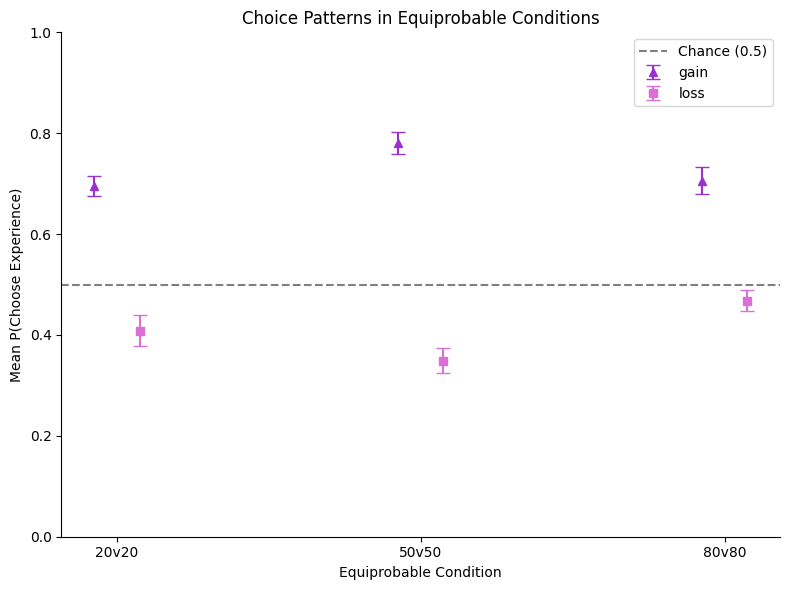

In [19]:
# Plot generation function for equiprobable conditions
def generate_equiprobable_choice_plot(data_dir):
    # Load and process the data
    combined_data = load_and_process_excel_files(data_dir)

    # Group data by type and equiprobable_condition, calculating mean, and SEM for choice
    grouped_context = combined_data.groupby(['type', 'equiprobable_condition'])['choice_num'].agg(['mean', 'sem']).reset_index()

    plt.figure(figsize=(8, 6))

    # Extract unique context types (gain/loss)
    contexts = grouped_context['type'].unique()

    x_positions = [2, 4, 6]
    x_labels = ["20v20", "50v50", "80v80"]

    # Loop through each context
    for context in contexts:
        # Filter data for the current context
        context_data = grouped_context[grouped_context['type'] == context]

        # Extract mean and SEM values for the conditions
        y_values = [context_data.loc[context_data['equiprobable_condition'] == cond, 'mean'].iloc[0] for cond in x_labels]
        errors = [context_data.loc[context_data['equiprobable_condition'] == cond, 'sem'].iloc[0] for cond in x_labels]

        # Set marker and color based on the context
        if context == 'gain':
            marker = '^'
            color = 'darkorchid'
            x_positions_context = [x - 0.15 for x in x_positions]  # Shift position left for 'gain'
        elif context == 'loss':
            marker = 's'
            color = 'orchid'
            x_positions_context = [x + 0.15 for x in x_positions]  # Shift position right for 'loss'
        else:
            marker = 'o'
            color = 'gray'
            x_positions_context = x_positions

        # Plot the data with error bars for the current context
        plt.errorbar(x_positions_context, y_values, yerr=errors, fmt=marker, label=context, capsize=5, color=color)

    # Add a horizontal line at y=0.5 for chance level
    plt.axhline(y=0.5, color='gray', linestyle='--', label='Chance (0.5)')

    # Remove top and right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add labels and title to the plot
    plt.xlabel('Equiprobable Condition')
    plt.ylabel('Mean P(Choose Experience)')
    plt.title('Choice Patterns in Equiprobable Conditions')

    # Set x-ticks and y-limits
    plt.xticks(x_positions, x_labels)
    plt.ylim(0, 1)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

    # Show legend
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run the plot generation function
generate_equiprobable_choice_plot(data_dir)

**Figure 1.** Choice patterns during the equiprobable description versus experience trials.

The dashed line at 0.5 represents the chance level, indicating no preference for either option.

---
# Data Visualization - Choice Patterns of Experiment 2

Visualizing choice patterns across different conditions (Train, Pure, Unequal) will allow examinations of decision-making biases. By plotting the probability of selecting the best option in gain and loss contexts, we can observe deviations from chance level to reveal potential risk preferences. This visualization could help guide in the understanding how different conditions influence decision behavior, making complex patterns more interpretable.

Data Processing and Visualization

* The `plot_conditions()` function generates a series of subplots to visualize choice patterns across different experimental conditions. It will:

  1.   Compute the **mean** and standard error of the mean (**SEM**) for **gain** and **loss** choices

  2.   Organize the data into a grouped dataframe

  3.   Define **Training, Pure, and Unequal** conditions

  4.   Generate three subplots (one for each condition) to visualize choice patterns:

   *   X-axis: Choice conditions (**20v50, 50v80, 20v80**)
  
   *   Y-axis: **Probability** of choosing the best option (p(Choose Best)), with error bars represent **SEM**

 5.  Markers and colors differentiate between:
  
    *   **Gain** vs. **Loss** `contexts`

    *   `Description-based` vs. `Experience-based` choices


Data Variables:

*   `gain_choice, loss_choice`: Participant choices in gain/loss contexts

*   `grouped_gain_choice, grouped_loss_choice`: Mean & SEM for gain/loss probabilities

* `conditions_train, conditions_pure, conditions_unequal`: Lists defining subsets of experimental conditions

* `x_positions`: [2, 4, 6], corresponding to choice conditions: "20v50", "50v80", "20v80"

*  `markers & colors`: Holds markers that differentiate Gain/Loss and Description/Experience choices

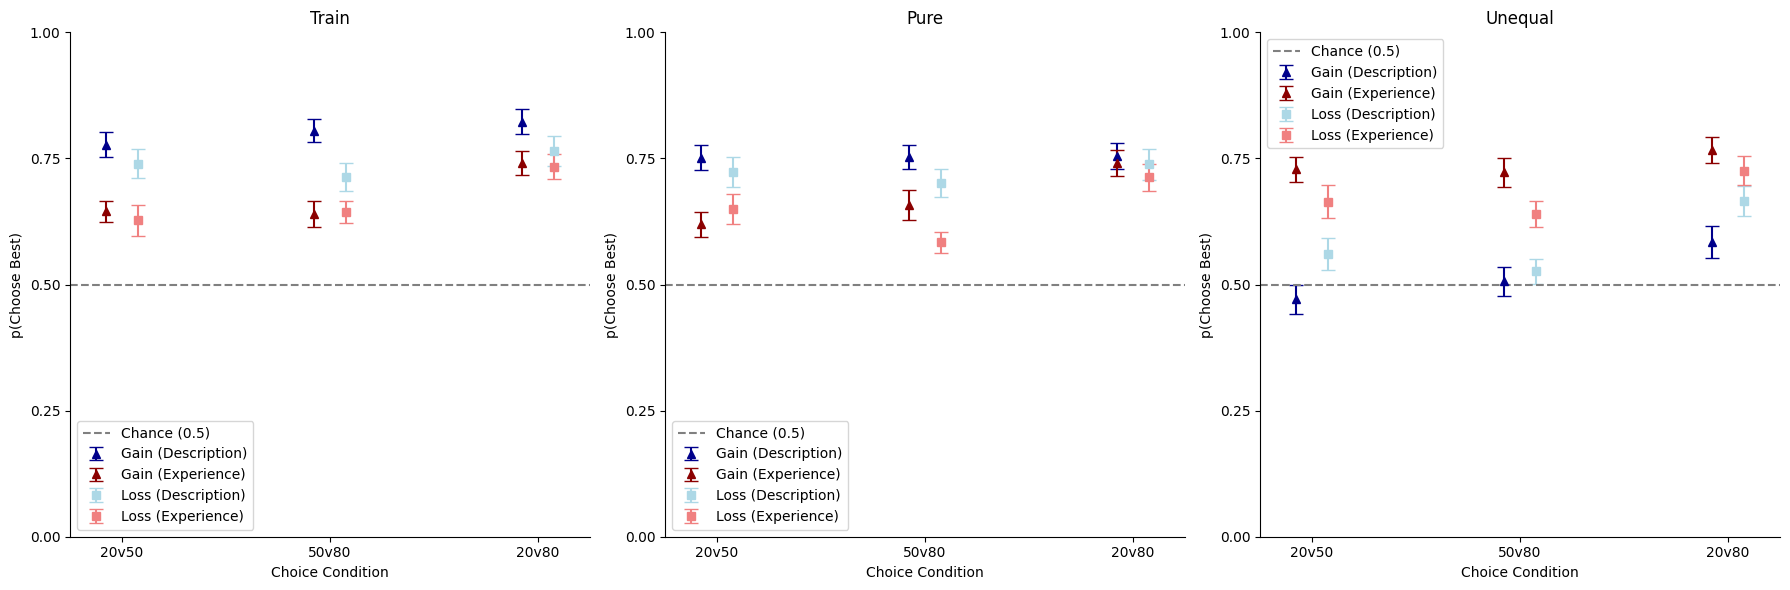

In [20]:
# Compute mean and SEM for gain_choice and store in dataframe
gain_mean = gain_choice.mean(axis=0, skipna=True)
gain_sem = gain_choice.sem(axis=0, skipna=True)
grouped_gain_choice = pd.DataFrame({'Mean': gain_mean, 'SEM': gain_sem})

# Compute mean and SEM for loss_choice and store in dataframe
loss_mean = loss_choice.mean(axis=0, skipna=True)
loss_sem = loss_choice.sem(axis=0, skipna=True)
grouped_loss_choice = pd.DataFrame({'Mean': loss_mean, 'SEM': loss_sem})

# Set up the figure and axis (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define x-axis positions and labels
x_positions = [2, 4, 6]
x_labels = ["20v50", "50v80", "20v80"]

# Define conditions for each plot
conditions_train = ['train_d_20v50', 'train_e_20v50', 'train_d_50v80', 'train_e_50v80', 'train_d_20v80', 'train_e_20v80']
conditions_pure = ['pure_d_20v50', 'pure_e_20v50', 'pure_d_50v80', 'pure_e_50v80', 'pure_d_20v80', 'pure_e_20v80']
conditions_unequal = ['ue_d_20v50', 'ue_e_20v50', 'ue_d_50v80', 'ue_e_50v80', 'ue_d_20v80', 'ue_e_20v80']

# Function to plot gain and loss data for each condition
def plot_conditions(ax, conditions, grouped_gain_choice, grouped_loss_choice):
    # Extract the mean and SEM values for the gain_choice conditions
    gain_means = grouped_gain_choice.loc[conditions, 'Mean'].values
    gain_sems = grouped_gain_choice.loc[conditions, 'SEM'].values

    # Extract the (1-mean) and SEM values for the loss_choice conditions
    loss_means = 1 - grouped_loss_choice.loc[conditions, 'Mean'].values
    loss_sems = grouped_loss_choice.loc[conditions, 'SEM'].values

    # Separate x positions for Description (d) and Experience (e) conditions
    # Shift position left for 'gain'
    x_positions_gain_d = [x - 0.15 for x in x_positions]
    x_positions_gain_e = [x - 0.15 for x in x_positions]

    # Shift position right for 'gain'
    x_positions_loss_d = [x + 0.15 for x in x_positions]
    x_positions_loss_e = [x + 0.15 for x in x_positions]

    # Markers and colors for plotting
    markers = {('gain', 'Description'): '^', ('loss', 'Description'): 's',
               ('gain', 'Experience'): '^', ('loss', 'Experience'): 's'}

    colors = {('gain', 'Description'): 'darkblue', ('loss', 'Description'): 'lightblue',
              ('gain', 'Experience'): 'darkred', ('loss', 'Experience'): 'lightcoral'}

    # Plot Gain Choice (Description & Experience)
    ax.errorbar(x_positions_gain_d, gain_means[::2], yerr=gain_sems[::2], fmt=markers[('gain', 'Description')],
                color=colors[('gain', 'Description')], label='Gain (Description)', capsize=5)

    ax.errorbar(x_positions_gain_e, gain_means[1::2], yerr=gain_sems[1::2], fmt=markers[('gain', 'Experience')],
                color=colors[('gain', 'Experience')], label='Gain (Experience)', capsize=5)

    # Plot Loss Choice (Description & Experience)
    ax.errorbar(x_positions_loss_d, loss_means[::2], yerr=loss_sems[::2], fmt=markers[('loss', 'Description')],
                color=colors[('loss', 'Description')], label='Loss (Description)', capsize=5)

    ax.errorbar(x_positions_loss_e, loss_means[1::2], yerr=loss_sems[1::2], fmt=markers[('loss', 'Experience')],
                color=colors[('loss', 'Experience')], label='Loss (Experience)', capsize=5)

    # Formatting
    ax.axhline(y=0.5, color='gray', linestyle='--', label='Chance (0.5)')
    ax.set_xticks([2, 4, 6])
    ax.set_xticklabels(["20v50", "50v80", "20v80"])
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_xlim(1.5, 6.5)

    # Remove top and right spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Labels and title
    ax.set_xlabel("Choice Condition")
    ax.set_ylabel("p(Choose Best)")
    ax.set_title("Choice Patterns")

    ax.legend()

# Plotting for Train, Pure, and Unequal conditions in 3 subplots
plot_conditions(axes[0], conditions_train, grouped_gain_choice, grouped_loss_choice)
axes[0].set_title("Train")

plot_conditions(axes[1], conditions_pure, grouped_gain_choice, grouped_loss_choice)
axes[1].set_title("Pure")

plot_conditions(axes[2], conditions_unequal, grouped_gain_choice, grouped_loss_choice)
axes[2].set_title("Unequal")

# Display plot
plt.tight_layout()
plt.show()

**Figure 2.** Choice Patterns Across Training, Pure, and Unequal Conditions

This figure displays the probability of participants choosing the better option, revealing how context (gain/loss) and stimulus type (description/experience) influence choices across different phases of the experiment.

The horizontal dashed line at 0.5 represents the chance level, indicating no preference for either option.

---
# Data Visualization - Reaction Time Patterns of Experiment 2

Visualizing reaction time (RT) across different choice conditions (Train, Pure, Unequal, and Equal) will explore decision-making speed. Analyzing RT can reveal cognitive effort, hesitation, or certainty in gain and loss contexts. By plotting mean RT with error bars (SEM), we can identify patterns, such as whether losses lead to longer deliberation or if experience-based choices differ from description-based ones. The visualization could provides insights into the underlying cognitive processes influencing decision speed, making it easier to interpret how different conditions affect reaction time.

Data Processing and Visualization

* The `rt_plot_conditions()` function generates four subplots to visualize reaction time (RT) differences across various experimental conditions. It will:

  1.   Compute the **mean** and **SEM** for **gain** and **loss** `RTs`

  2.   Organize the data into a grouped dataframe

  3.   Define **Training, Pure, Unequal, and Equal** conditions

  4.   Generate four subplots to visualize `RT` differences:

    *   X-axis: Choice conditions (**20v50, 50v80, 20v80** for most; **20v20, 50v50, 80v80** for Equal)
  
    *   Y-axis: `Reaction time` (RT) in milliseconds

  5.   Markers and colors differentiate between:

    *   **Gain** vs. **Loss** `RTs`

    *   `Description-based` vs. `Experience-based` choices

Data Variables:

*   `gain_rt & loss_rt`: RTs for gain and loss conditions

*   `grouped_rt_gain_choice & grouped_rt_loss_choice`: Mean and standard error of the mean (SEM) for gain and loss RTs

* `Choice Conditions`: Trials categorized into:

  * **Training**, **Pure**, **Unequal**, and **Equal** phases
  
  * **"d"** = Description-based choices, **"e"** = Experience-based choices

*  `x_positions`: X-axis positions for different choice conditions

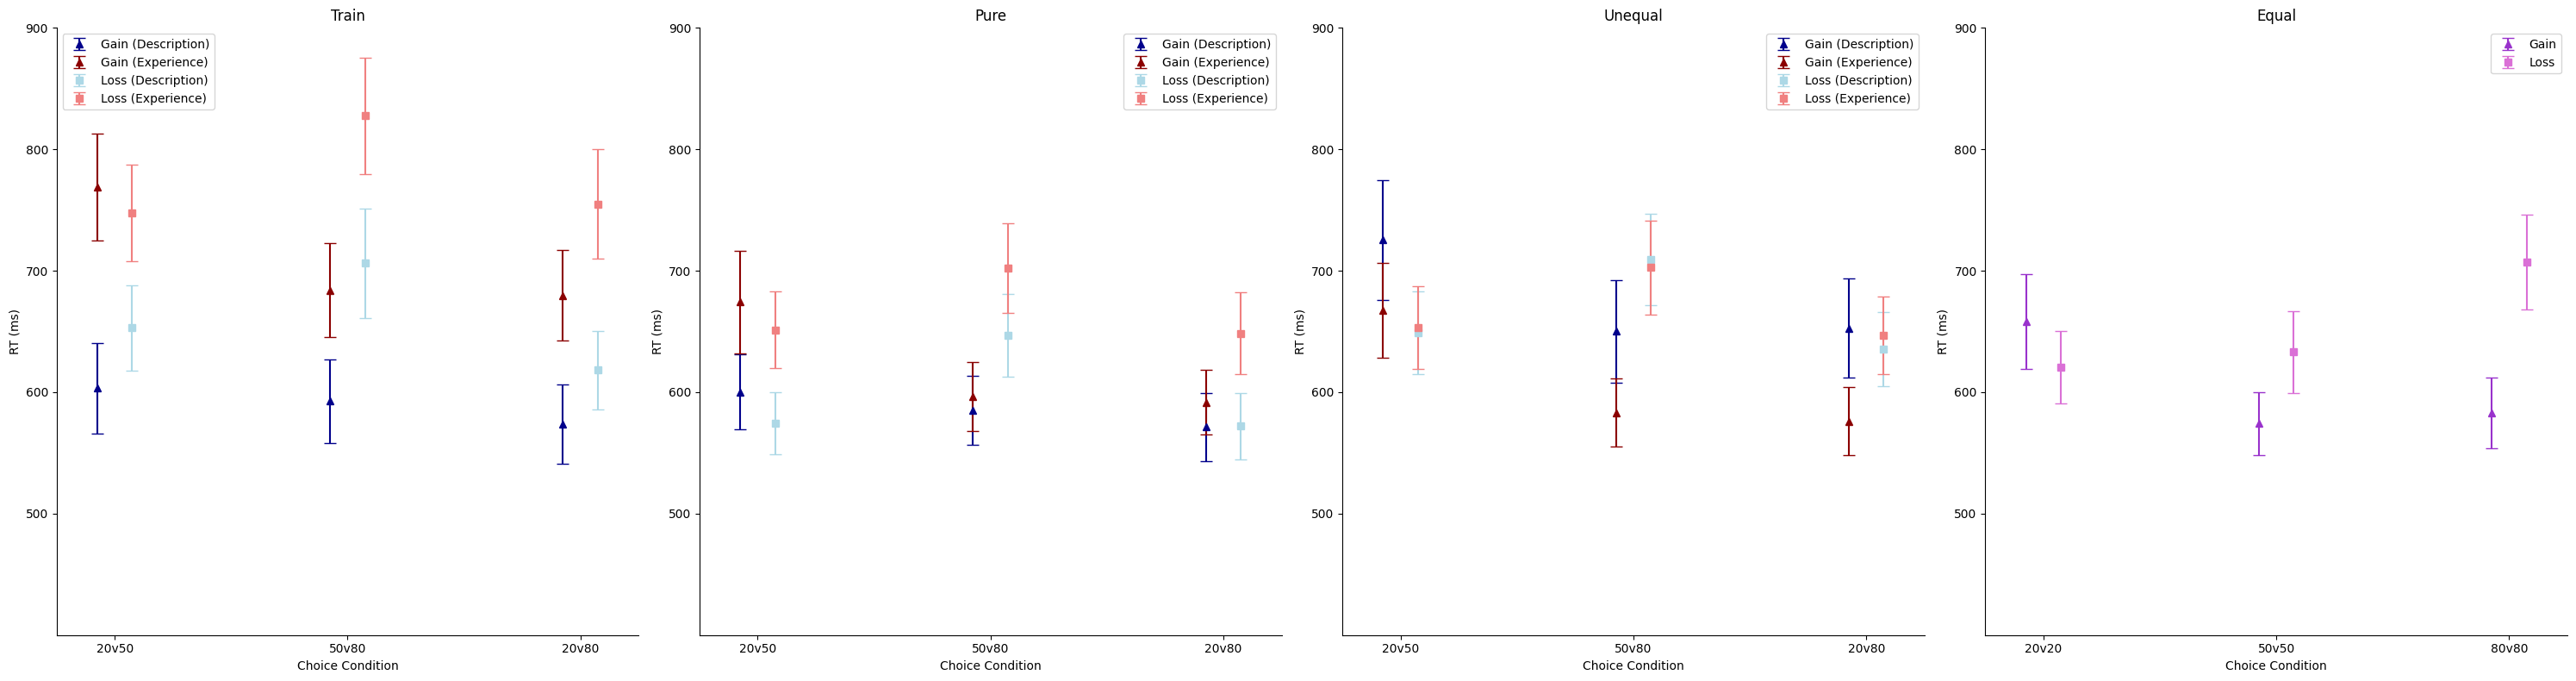

In [21]:
# Compute mean and SEM for gain_rt
gain_mean_rt = gain_rt.mean(axis=0, skipna=True)
gain_sem_rt = gain_rt.sem(axis=0, skipna=True)
grouped_rt_gain_choice = pd.DataFrame({'Mean': gain_mean_rt, 'SEM': gain_sem_rt})

# Compute mean and SEM for loss_choice
loss_mean_rt = loss_rt.mean(axis=0, skipna=True)
loss_sem_rt = loss_rt.sem(axis=0, skipna=True)
grouped_rt_loss_choice = pd.DataFrame({'Mean': loss_mean_rt, 'SEM': loss_sem_rt})

# Set up the figure and axis (1 row, 4 columns)
fig, axes = plt.subplots(1, 4, figsize=(30, 8))

# Define x-axis positions and labels
x_positions = [2, 4, 6]

# Define conditions for each plot (same as before)
conditions_train = ['train_d_20v50', 'train_e_20v50', 'train_d_50v80', 'train_e_50v80', 'train_d_20v80', 'train_e_20v80']
conditions_pure = ['pure_d_20v50', 'pure_e_20v50', 'pure_d_50v80', 'pure_e_50v80', 'pure_d_20v80', 'pure_e_20v80']
conditions_unequal = ['ue_d_20v50', 'ue_e_20v50', 'ue_d_50v80', 'ue_e_50v80', 'ue_d_20v80', 'ue_e_20v80']
conditions_equal = ['eq_20v20', 'eq_50v50', 'eq_80v80']

# Function to plot gain and loss RT data for each condition
def rt_plot_conditions(ax, conditions, grouped_gain_rt, grouped_loss_rt):
    # Get the means and SEMs for the gain and loss conditions
    gain_means = grouped_gain_rt.loc[conditions, 'Mean'].values
    gain_sems = grouped_gain_rt.loc[conditions, 'SEM'].values

    loss_means = grouped_loss_rt.loc[conditions, 'Mean'].values
    loss_sems = grouped_loss_rt.loc[conditions, 'SEM'].values

    # Separate x positions for Description (d) and Experience (e) conditions
    x_positions_gain_d = [x - 0.15 for x in x_positions]  # Shift Gain to the left
    x_positions_gain_e = [x - 0.15 for x in x_positions]  # Shift Gain Experience to the right

    x_positions_loss_d = [x + 0.15 for x in x_positions]  # Shift Loss to the left
    x_positions_loss_e = [x + 0.15 for x in x_positions]  # Shift Loss Experience to the right

    if len(conditions) == 3:
        # Markers and colors for plotting
        markers = {('gain'): '^', ('loss'): 's'}

        colors = {('gain'): 'darkorchid', ('loss'): 'orchid'}

        # Plot Gain Choice and Loss Choice
        ax.errorbar(x_positions_gain_d, gain_means, yerr=gain_sems, fmt=markers[('gain')],
                    color=colors[('gain')], label='Gain', capsize=5)

        ax.errorbar(x_positions_loss_d, loss_means, yerr=loss_sems, fmt=markers[('loss')],
                    color=colors[('loss')], label='Loss', capsize=5)

        # Formatting
        ax.set_xticks([2, 4, 6])
        ax.set_xticklabels(["20v20", "50v50", "80v80"])
        ax.set_yticks([500, 600, 700, 800, 900])
        ax.set_ylim(400, 900)
        ax.set_xlim(1.5, 6.5)

        # Remove top and right spines for a cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Labels and title
        ax.set_xlabel("Choice Condition")
        ax.set_ylabel('RT (ms)')
        ax.set_title(f"RT by Condition")
        ax.legend()

    else:
        # Markers and colors for plotting
        markers = {('gain', 'Description'): '^', ('loss', 'Description'): 's',
                ('gain', 'Experience'): '^', ('loss', 'Experience'): 's'}

        colors = {('gain', 'Description'): 'darkblue', ('loss', 'Description'): 'lightblue',
                ('gain', 'Experience'): 'darkred', ('loss', 'Experience'): 'lightcoral'}

        # Plot Gain Choice (Description & Experience)
        ax.errorbar(x_positions_gain_d, gain_means[::2], yerr=gain_sems[::2], fmt=markers[('gain', 'Description')],
                    color=colors[('gain', 'Description')], label='Gain (Description)', capsize=5)

        ax.errorbar(x_positions_gain_e, gain_means[1::2], yerr=gain_sems[1::2], fmt=markers[('gain', 'Experience')],
                    color=colors[('gain', 'Experience')], label='Gain (Experience)', capsize=5)

        # Plot Loss Choice (Description & Experience)
        ax.errorbar(x_positions_loss_d, loss_means[::2], yerr=loss_sems[::2], fmt=markers[('loss', 'Description')],
                    color=colors[('loss', 'Description')], label='Loss (Description)', capsize=5)

        ax.errorbar(x_positions_loss_e, loss_means[1::2], yerr=loss_sems[1::2], fmt=markers[('loss', 'Experience')],
                    color=colors[('loss', 'Experience')], label='Loss (Experience)', capsize=5)

        # Formatting
        ax.set_xticks([2, 4, 6])
        ax.set_xticklabels(["20v50", "50v80", "20v80"])
        ax.set_yticks([500, 600, 700, 800, 900])
        ax.set_ylim(400, 900)
        ax.set_xlim(1.5, 6.5)

        # Remove top and right spines for a cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Labels and title
        ax.set_xlabel("Choice Condition")
        ax.set_ylabel('RT (ms)')
        ax.set_title(f"RT by Condition")
        ax.legend()

# Plot for training conditions
rt_plot_conditions(axes[0], conditions_train, grouped_rt_gain_choice, grouped_rt_loss_choice)
axes[0].set_title('Train')

# Plot for pure conditions
rt_plot_conditions(axes[1], conditions_pure, grouped_rt_gain_choice, grouped_rt_loss_choice)
axes[1].set_title('Pure')

# Plot for unequal conditions
rt_plot_conditions(axes[2], conditions_unequal, grouped_rt_gain_choice, grouped_rt_loss_choice)
axes[2].set_title('Unequal')

rt_plot_conditions(axes[3], conditions_equal, grouped_rt_gain_choice, grouped_rt_loss_choice)
axes[3].set_title("Equal")

# Display plot
plt.tight_layout()
plt.show()

**Figure 3.** Reaction Times (RTs) Across Conditions.

This figure displays the reaction times (RTs) of participants, revealing how context (gain/loss) and stimulus type (description/experience) influenced decision-making speed across different trial types.

# Data Visualization - Q-Learning Model Performance


Visualizing the performance of a Q-learning agent across different learning rates (alpha values) and gain/loss contexts will explore how well this reinforcement learning model can predict participants' choices. By plotting the mean accuracy of the model against different alpha values, separately for gain and loss conditions, we can identify optimal learning rates for each context. Comparing the model's accuracy to the actual participant accuracy will provide insights into the model's ability to capture human decision-making processes under varying reward structures.




Data Processing and Visualization

* Defining a `QLearningAgent` class: This class implements a basic Q-learning agent with a state mapping for different stimulus types (experience-based and description-based with neutral probabilities). It includes methods to update Q-values based on rewards and retrieve the current Q-values:

*   Implementing an `evaluate_agent` function: This function takes an alpha value, a dataframe of participant data, and the experimental context (**"Gain?** or **"Loss"**) as input. It simulates the Q-learning agent's decision-making process based on the provided data, updates the agent's Q-values after each trial, and returns the accuracy of the agent's predictions compared to the participant's choices.

*   Implementing a `calculate_participant_accuracy` function: This function calculates the actual accuracy of the participants in making choices that lead to a reward in the given context (**"Gain?** or **"Loss"**).

*   Calculating **mean accuracies**: The code calculates the mean model accuracy across all data files for each **alpha** value, separately for **gain** and **loss** conditions.

*   Generating a `plot`: Finally, it creates a line plot showing the mean model accuracy as a function of the **alpha** value for both **gain** and **loss** conditions. This plot helps visualize the relationship between the learning rate and the model's performance in different contexts.

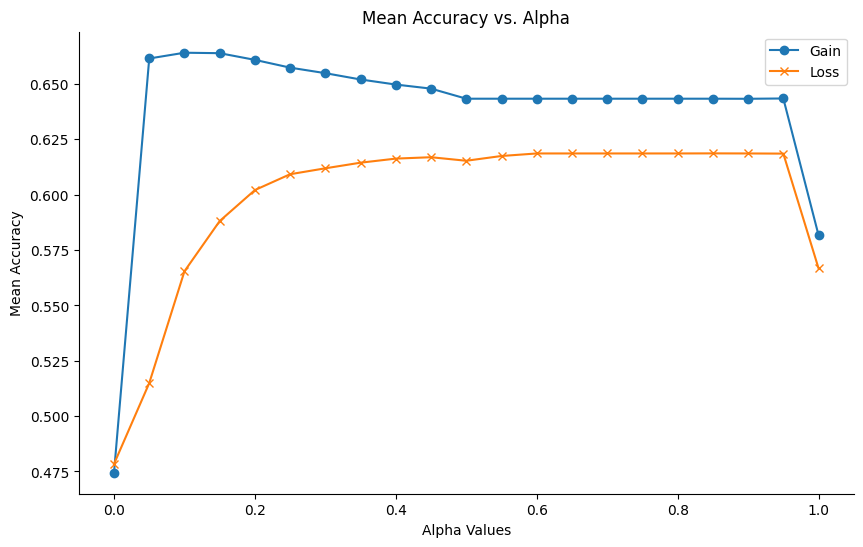

In [22]:
class QLearningAgent:
    def __init__(self, alpha):
        self.state_mapping = {
            "expe_20": 0, # experience with 20%
            "expe_50": 1, # experience with 50%
            "expe_80": 2, # experience with 80%
            "desc_20": 3, # description with 20%
            "desc_50": 4, # description with 50%
            "desc_80": 5  # description with 80%
        }
        self.Q = np.full(len(self.state_mapping), 0.5) # neutral starting point for learning
        self.alpha = alpha #learning rate

    def update(self, stimulus, reward): # RL model learning algorithm
        if stimulus in self.state_mapping:
            index = self.state_mapping[stimulus]
            self.Q[index] += self.alpha * (reward - self.Q[index])

    def get_Q(self):
        return self.Q

def evaluate_agent(alpha, df, context):
    agent = QLearningAgent(alpha) # creates one class agent
    correct_choices = 0
    total_choices = 0

    for _, row in df.iterrows(): # iterater

        # extract essential information
        left_type = row['imageTypeLeft'].lower()
        right_type = row['imageTypeRight'].lower()
        chosen_type = row['chosenImageType'].lower()
        response_side = row['response_side'].lower()
        reward = row['rewardCode']
        prob_left = row['imageProbLeft']
        prob_right = row['imageProbRight']

        # extract stimulus information
        left_stimulus = f"{left_type[:4]}_{int(prob_left * 100)}"
        right_stimulus = f"{right_type[:4]}_{int(prob_right * 100)}"

        # Q-values for the left and right stimuli
        Q_left = agent.get_Q()[agent.state_mapping[left_stimulus]]
        Q_right = agent.get_Q()[agent.state_mapping[right_stimulus]]

        # agent prediction model when right stimulus prob > left right stimulus prob
        predicted_choice = "right" if Q_right > Q_left else "left"

        # counter for accuracy in terms of replicating decisions
        if predicted_choice == response_side:
            correct_choices += 1
        total_choices += 1

        # actual particpant chose decision
        chosen_stimulus = right_stimulus if response_side == "right" else left_stimulus

        # updating new probabilities, so model learns
        agent.update(chosen_stimulus, reward)

    # returning accuracy %
    return correct_choices / total_choices if total_choices > 0 else 0

# calculating actual participant accuracy in making the correct choices
def calculate_participant_accuracy(df, context):
    correct_choices = 0
    total_choices = 0

    #iterater
    for _, row in df.iterrows():

        # extracting essential information
        response_side = row['response_side'].lower()
        reward = row['rewardCode']

        # conditions to gain reward
        if (context == "Gain" and reward == 1) or (context == "Loss" and reward == -1):
            if response_side == "right":
              correct_choices +=1
            elif response_side == "left":
              correct_choices+=1
        total_choices += 1

    return correct_choices / total_choices if total_choices > 0 else 0    #returning participant accuracy

alpha_values = np.arange(0.0, 1.05, 0.05)

results = []
gain_accuracies_all_files = []
loss_accuracies_all_files = []

# iterater
for this_file in os.listdir(data_dir):
    if this_file.endswith('.xlsx'):
        file_path = os.path.join(data_dir, this_file)
        file_df = pd.read_excel(file_path)

        required_columns = {'imageTypeLeft', 'imageTypeRight', 'chosenImageType', 'response_side', 'imageProbLeft', 'imageProbRight', 'rewardCode', 'type'}
        if required_columns.issubset(file_df.columns):
            # seperate into gain and loss conditions
            gain_df = file_df[file_df['type'] == 'gain'].copy()
            loss_df = file_df[file_df['type'] == 'loss'].copy()
            loss_df.loc[:, "rewardCode"] = loss_df["rewardCode"] * -1 # invert loss reward coding

            gain_accuracies = []
            loss_accuracies = []

            for alpha in alpha_values: # iterate through each alpha value and call function that calls class
                gain_accuracies.append(evaluate_agent(alpha, gain_df, "Gain"))
                loss_accuracies.append(evaluate_agent(alpha, loss_df, "Loss"))

            # store accuracies
            gain_accuracies_all_files.append(gain_accuracies)
            loss_accuracies_all_files.append(loss_accuracies)

            # get best alpha gain and loss values
            best_gain_alpha_index = np.argmax(gain_accuracies)
            best_loss_alpha_index = np.argmax(loss_accuracies)
            best_gain_alpha = alpha_values[best_gain_alpha_index]
            best_loss_alpha = alpha_values[best_loss_alpha_index]

            # get associated best model accuracies
            best_gain_model_accuracy = gain_accuracies[best_gain_alpha_index]
            best_loss_model_accuracy = loss_accuracies[best_loss_alpha_index]

            # get associated actual participant accuracy
            participant_gain_accuracy = calculate_participant_accuracy(gain_df, "Gain")
            participant_loss_accuracy = calculate_participant_accuracy(loss_df, "Loss")

            # store results
            results.append({
                'file': this_file,
                'gain_alpha_best': best_gain_alpha,
                'gain_model_accuracy_best': best_gain_model_accuracy,
                'gain_participant_accuracy_best': participant_gain_accuracy,
                'loss_alpha_best': best_loss_alpha,
                'loss_model_accuracy_best': best_loss_model_accuracy,
                'loss_participant_accuracy_best': participant_loss_accuracy
            })
results_df = pd.DataFrame(results)

# calculate mean accuracies across all files for each alpha value
mean_gain_accuracies = np.mean(gain_accuracies_all_files, axis=0)
mean_loss_accuracies = np.mean(loss_accuracies_all_files, axis=0)

# plot mean accuracy for both gain and loss conditions
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, mean_gain_accuracies, label='Gain', marker='o')
plt.plot(alpha_values, mean_loss_accuracies, label='Loss', marker='x')
plt.xlabel('Alpha Values')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs. Alpha')

# Remove top and right spines for a cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()
plt.show()

**Figure 4.** Mean Accuracy vs. Alpha.

This figure shows the mean accuracy achieved by the model as a function of the alpha parameter, highlighting the contrasting effects of gain and loss conditions on performance across varying alpha values.









---
# Discussion

This study investigated how people make choices when faced with options presented as either "experiences" (like emojis) or "descriptions" (like bar graphs) and how these choices are influenced by whether the options represent potential gains or losses. Visualizing equiprobable conditions (20v20, 50v50, 80v80) helped uncover whether participants’ choices deviated from a neutral chance level, revealing potential biases in decision-making. The data showed that participants did not always choose randomly in these conditions, suggesting that probability perception influenced their decisions and potentially indicated risk preferences.

The data supports that the way choices were framed significantly impacted decisions. Specifically, participants who were trying to maximize gains (gain-seeking) showed a strong preference for experience options, while those trying to minimize losses (loss-mitigating) preferred description options. By analyzing choice patterns across different conditions (Train, Pure, Unequal), we observed systematic deviations from chance level, further highlighting how different contexts influenced decision biases. This visualization made it easier to interpret how probability perception affected risk-taking tendencies. The loss context made the task more challenging, indicating that the emotional weight of potential losses can interfere with decision-making. Further support for this comes from the analysis of a Q-learning model, where in the gain context, the model's accuracy in predicting participant choices plateaus at a high level across a wide range of learning rates (alpha), while in the loss context, the model's accuracy is lower and more sensitive to alpha, indicating higher variability in decision-making.

The study also examined reaction times, providing insights into the cognitive effort involved in different choices. By visualizing reaction time (RT) across choice conditions (Train, Pure, Unequal, and Equal), we explored decision-making speed and hesitation. Participants responded faster to description options than experience options, suggesting that descriptions might be processed more efficiently. Additionally, larger probability differences led to faster decisions, indicating that when the choice was clearer, people responded more quickly. Conversely, the loss context slowed down responses, suggesting that dealing with potential losses required more cognitive effort. Interestingly, gain-seeking participants responded faster when experience stimuli were "better," and loss-mitigating participants were faster when description stimuli were "better," aligning with their choice patterns. Furthermore, reaction times in loss conditions increased as the probability of loss grew, reinforcing the idea that loss aversion imposes a greater cognitive burden. These findings highlight how RT serves as an indicator of hesitation, certainty, and cognitive load, providing deeper insight into the underlying decision-making processes. The "Mean Accuracy vs. Alpha" figure also reinforces this by showing the Q-learning model's lower accuracy in the loss context could be due to the increased cognitive load associated with losses that lead to more variable choices.


The analysis of participant choice behavior data provides evidence that outcome uncertainty and gain/loss contexts significantly influence decision-making. Participants' choices deviated from chance level, suggesting probability perception and risk preferences shaped decision biases. Gain-seekers favored experience-based options, while loss-mitigators preferred description-based ones. Reaction time data further supported this, showing that loss contexts increased cognitive load and decision difficulty. The Q-learning model's performance also reflects this, by highlighting the model's limitations in capturing the complexity of decision-making, seen in the loss context.  However, the study has some limitations. One concern is the confounding of stimulus type with experience/description categories. Because emojis were always used for experience options and bar graphs for description options, it's difficult to determine whether the observed differences in choice and reaction time were due to the experience/description framing itself or simply the visual differences between emojis and bars. Additionally, the study only examined a limited range of probability conditions, which restricts the generalizability of the findings. The findings suggest that both uncertainty and gain/loss framing play a critical role in choice behavior, warranting further research with controlled visual presentations and expanded probability conditions.